# Projections

In [25]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt

from scipy.stats import norm
import statistics
from statistics import NormalDist

from sklearn.metrics import confusion_matrix

from statistics import NormalDist

In [4]:
iris = datasets.load_iris()

X = iris['data']
y = iris['target']

df = pd.DataFrame(X)
df['Class'] = y

df.columns=['F1', 'F2', 'F3', 'F4', 'Class']

# DBSCAN

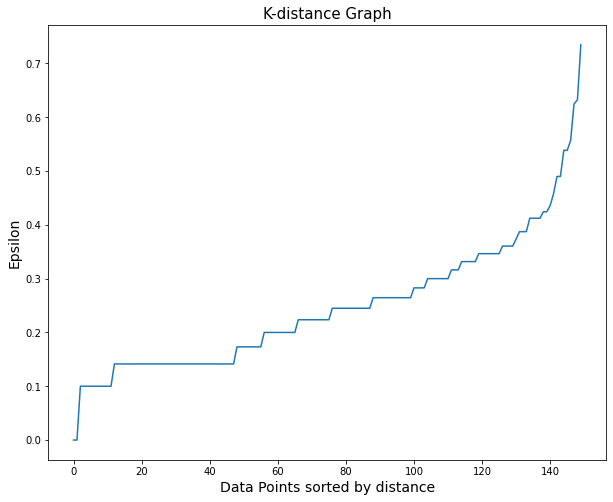

In [28]:
# To help find the value of epsilon

neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=15)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [29]:
dbscan = DBSCAN(eps=0.4, min_samples=5).fit(X)

In [30]:
y_pred = dbscan.labels_
y_pred

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,
       -1,  1,  2,  1,  2,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  2, -1,
       -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  2,
        3,  3,  3, -1, -1, -1, -1, -1,  3,  3,  3,  2, -1,  3,  3, -1, -1,
       -1,  3,  2, -1,  2,  3, -1,  2,  2,  3, -1, -1, -1,  3,  2, -1, -1,
        3,  3,  2,  3,  3,  3,  2,  3,  3,  3,  2,  3,  3,  2])

In [31]:
num_outliers = (np.sum(np.array(y_pred) == -1, axis=0))
num_clusters = (len(set(y_pred)) - (1 if -1 in y_pred else 0))
print('Number of noise points: ', num_outliers)
print("Number of clusters: ", num_clusters)

Number of noise points:  32
Number of clusters:  4


In [32]:
# After clustering, we have our clusters. 
# But need to see within each cluster, what is the actual class distribution of the datapoints

def difference_in_labels(y_pred, cluster_number):
    index = list(np.where(y_pred == cluster_number)[0])
    cluster_data = df.iloc[index, :]
    return cluster_data[['Class']].value_counts()

In [33]:
# Noise points
difference_in_labels(y_pred, -1)

Class
2        17
1        11
0         4
dtype: int64

In [34]:
# From those assigned cluster 0 from DBSCAN, all of them are from the same class in the dataset.
difference_in_labels(y_pred, 0)

Class
0        46
dtype: int64

In [35]:
difference_in_labels(y_pred, 1)

Class
1        36
dtype: int64

In [36]:
# From those assigned cluster 2 from DBSCAN, some of them belong to class 1 and 2 of the dataset.

difference_in_labels(y_pred, 2)

Class
2        11
1         3
dtype: int64

In [37]:
difference_in_labels(y_pred, 3)

Class
2        22
dtype: int64

In [82]:
# Functions to get the gaussian projections of all clusters on one specific axis

# Gets the datapoints and centroid coordinates for a particular cluster
def get_data_centroid(X, y_pred, cluster_label):
    datapoints = X[y_pred==cluster_label,:]
    centroid_coord = np.mean(datapoints, axis=0) 
    return datapoints, centroid_coord

# Gets the mean and std of a particular cluster (for 1 dimension only)
def mean_std(cluster_data, dim):
    points = cluster_data[:,dim]
    return statistics.mean(points), statistics.stdev(points)

# Gets the data required for each dimension (for all clusters)
def get_dimension_dict(X, num_clusters, dim, y_pred):
    dim_dict = {}
    
    for i in range(num_clusters):
        dim_dict["cluster"+str(i)] = {}
        data, centroid = get_data_centroid(X, y_pred, i)
        data_mean, data_std = mean_std(data, dim)
        dim_dict["cluster"+str(i)]["data"] = data
        dim_dict["cluster"+str(i)]["centroid"] = centroid
        dim_dict["cluster"+str(i)]["mean"] = data_mean
        dim_dict["cluster"+str(i)]["std"] = data_std
        
    return dim_dict

# Plot the gaussian projections of each cluster on the specified dimension
def plot_projection(dim_dict, num_clusters, title):
    
    plt.subplot(1,1,1)
    plt.title(title)
    for i in range(num_clusters):
        mean = dim_dict["cluster"+str(i)]["mean"]
        std = dim_dict["cluster"+str(i)]["std"]
        x = np.linspace(mean - 6*std, mean+6*std, 100)
        y = norm.pdf(x, mean, std)
        plt.plot(x, y/max(y), label="Cluster #"+str(i))
        
    plt.legend(bbox_to_anchor=(1.35, 0.7))

In [53]:
def gaussian_overlap(mu1, sigma1, mu2, sigma2):
    overlap = NormalDist(mu=mu1, sigma=sigma1).overlap(NormalDist(mu=mu2, sigma=sigma2))
    return overlap

def calc_overlap(dim_dict, index1, index2):
    mu1 = dim_dict["cluster"+str(index1)]["mean"]
    sigma1 = dim_dict["cluster"+str(index1)]["std"]
    mu2 = dim_dict["cluster"+str(index2)]["mean"]
    sigma2 = dim_dict["cluster"+str(index2)]["std"]
    return gaussian_overlap(mu1, sigma1, mu2, sigma2)

## Projections for DBSCAN

In [14]:
for i in range(num_clusters):
    print("centroid", str(i), ": ", get_data_centroid(X, y_pred, i)[1])

centroid 0 :  [4.99347826 3.41521739 1.48043478 0.24347826]
centroid 1 :  [6.03888889 2.84166667 4.33611111 1.33611111]
centroid 2 :  [6.01428571 2.77857143 4.96428571 1.79285714]
centroid 3 :  [6.59090909 3.08181818 5.50909091 2.15      ]


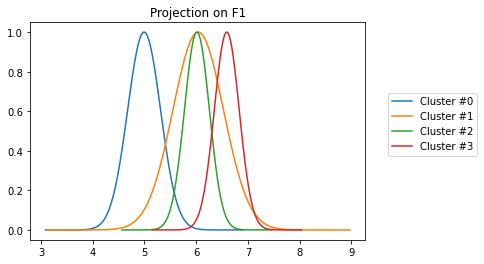

In [83]:
dim = 0
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F1")

In [57]:
calc_overlap(dim_dict, 1, 2)

0.6716130607595483

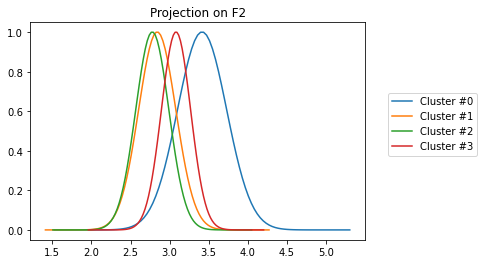

In [84]:
dim = 1
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F2")

In [63]:
calc_overlap(dim_dict, 1, 2)

0.8794494297452349

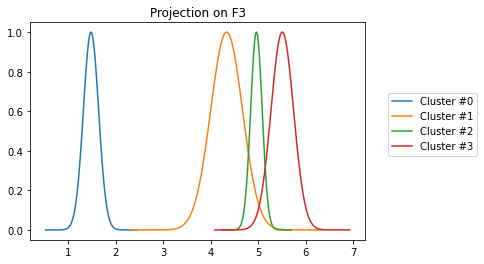

In [85]:
dim = 2
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F3")

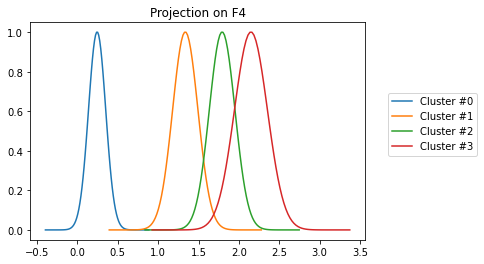

In [86]:
dim = 3
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F4")

# K Means

In [87]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(X)

In [88]:
y_pred = kmeans.labels_
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

In [89]:
difference_in_labels(y_pred, 0)

Class
1        48
2        14
dtype: int64

In [90]:
difference_in_labels(y_pred, 1)

Class
0        50
dtype: int64

In [91]:
difference_in_labels(y_pred, 2)

Class
2        36
1         2
dtype: int64

## Projection for K Means

In [92]:
centroids = kmeans.cluster_centers_
centroids

array([[5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
       [5.006     , 3.428     , 1.462     , 0.246     ],
       [6.85      , 3.07368421, 5.74210526, 2.07105263]])

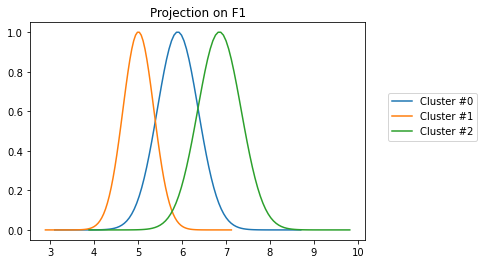

In [93]:
dim = 0
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F1")

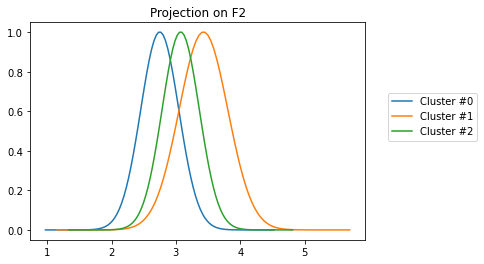

In [94]:
dim = 1
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F2")

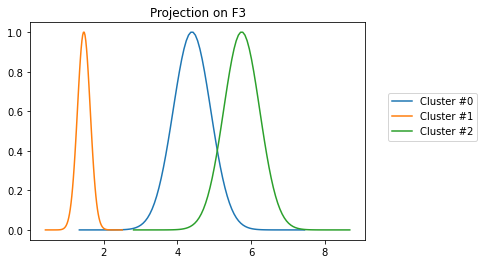

In [95]:
dim = 2
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F3")

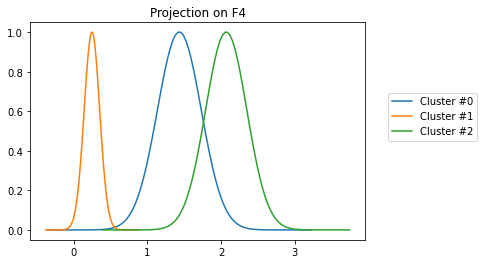

In [96]:
dim = 3
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F4")

# ELM + KMeans

https://github.com/sumanth-bmsce/Unsupervised_Extreme_Learning_Machine/blob/master/k_means.py

In [97]:
from sklearn import preprocessing
import random
import math
import sklearn.datasets
from itertools import groupby

In [108]:
def k_means_custom(data, no_of_clusters):
    print("Running K-means...")
    data = np.array(data)
    kmeans = KMeans(no_of_clusters, random_state=0).fit_predict(data)
    
    l1=kmeans[:50]
    l1.sort()
    l = [len(list(group)) for key, group in groupby(l1)]
    max1 = max(l)
    
    l1=kmeans[50:100]
    l1.sort()
    l = [len(list(group)) for key, group in groupby(l1)]
    max2 = max(l)
    
    l1=kmeans[100:150]
    l1.sort()
    l = [len(list(group)) for key, group in groupby(l1)]
    max3 = max(l)
    
    print("Clustering Accuracy = "+str(((max1+max2+max3)/150*100))+ " % ")
    return kmeans

In [160]:
def regression_matrix(input_array,input_hidden_weights,bias):
    input_array = np.array(input_array)
    input_hidden_weights = np.array(input_hidden_weights)
    bias = np.array(bias)
    regression_matrix = np.add(np.dot(input_array,input_hidden_weights),bias)
    return regression_matrix

# Finding hidden layer activations
def hidden_layer_matrix(regression_matrix):
    sigmoidal = [[0.0 for i in range(0,no_of_hidden_neurons)]for j in range(0,no_of_inputs)]
    for i in range(0,no_of_inputs):
        for j in range(0,no_of_hidden_neurons):
            sigmoidal[i][j] = (1.0)/(1+math.exp(-(regression_matrix[i][j])))    
    return sigmoidal

# Calculating the similarity matrix (S)
def similarity_matrix():
    dist_array = [[0.0 for i in range(0,no_of_inputs)]for j in range(0,no_of_inputs)]
    for i in range(0,no_of_inputs):
        for j in range(0,no_of_inputs):
            for k in range(0,input_dim):
                dist_array[i][j] +=  pow((input_array[i][k] - input_array[j][k]),2)
    
    for i in range(0, no_of_inputs):
        for j in range(0, no_of_inputs):
            dist_array[i][j] = math.exp((-(dist_array[i][j]))/(2*pow(sigma,2.0)))
    return dist_array

# Calculation of Graph Laplacian (L)
def laplacian_matrix(similarity_matrix):
    diagonal_matrix = [[0.0 for i in range(0,no_of_inputs)]for j in range(0,no_of_inputs)]
    diagonal_matrix = np.array(diagonal_matrix)
    similarity_matrix = np.array(similarity_matrix)
    for i in range(0,no_of_inputs):
        for j in range(0,no_of_inputs):
            diagonal_matrix[i][i] += similarity_matrix[i][j]
    
    return np.subtract(diagonal_matrix,similarity_matrix)

In [161]:
print("Running ELM...")

input_dim=4

# Loading Iris Dataset
iris = sklearn.datasets.load_iris()
data = iris.data[:, :4]

# Min-Max Normalization 
# min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.1,0.9))
# input_array = min_max_scaler.fit_transform(data)
input_array = X

input_array = np.array(input_array)
no_of_inputs = 150
no_of_input_neurons = input_dim
no_of_hidden_neurons = 120
no_of_output_neurons = 100
sigma = 1000
input_hidden_weights = [[random.uniform(0,1) for i in range(0,no_of_hidden_neurons)]for j in range(0,no_of_input_neurons)]

bias = [[1.0 for i in range(0,no_of_hidden_neurons)]for j in range(0,no_of_inputs)]
trade_off_parameter = 0.000000000000000000000000000001


hidden_matrix  = np.array(hidden_layer_matrix(regression_matrix(input_array,input_hidden_weights,bias)))

laplacian_matrix=np.array(laplacian_matrix(similarity_matrix()))
intermediate = np.dot(np.dot(hidden_matrix.T,laplacian_matrix),hidden_matrix)


a = [[0.0 for i in range(0,no_of_hidden_neurons)]for j in range(0,no_of_hidden_neurons)]
for i in range(0,no_of_hidden_neurons):
    for j in range(0,no_of_hidden_neurons):
        a[i][i] = 1.0
a = np.array(a)
a = np.add(a,trade_off_parameter*intermediate)

eig_value , eig_vector = np.linalg.eig(a)

eig_vector = eig_vector.T
req_eigen_vectors = [[0.0 for i in range(0,no_of_hidden_neurons)] for j in range(0,no_of_output_neurons)]
req_eigen_vectors = np.array(req_eigen_vectors)

# Sorting the eigen vectors using the eigen values
for i in range(0,len(eig_value)-1):
    for j in range(0,len(eig_value)-i-1):
        if(eig_value[j]>eig_value[j+1]):
            eig_value[j],eig_value[j+1]=eig_value[j+1],eig_value[j]
            eig_vector[j],eig_vector[j+1]=eig_vector[j+1],eig_vector[j]
             
# Finding n0 smallest eigen values
for i in range(0,no_of_output_neurons):
    req_eigen_vectors[i] = eig_vector[i]
    
    req_eigen_vectors[i] = np.divide(req_eigen_vectors[i],np.linalg.norm(np.dot(hidden_matrix,req_eigen_vectors[i].T)))

hidden_matrix = np.array(hidden_matrix)
req_eigen_vectors = np.array(req_eigen_vectors)

output_matrix = np.dot(hidden_matrix,(req_eigen_vectors.T))

i=0
print("Final Weights: ")
print(req_eigen_vectors)

num_clusters = 3
y_pred = k_means_custom(output_matrix,num_clusters)

Running ELM...
Final Weights: 
[[-8.92435358e-18  1.29693470e-02  3.86995214e-03 ...  1.93112364e-04
   5.46774004e-03  1.71167784e-04]
 [-2.08766035e-18  1.74712146e-03 -3.73606873e-03 ...  4.01146888e-04
  -6.34756265e-03 -4.80934042e-04]
 [-2.08766035e-18  1.74712146e-03 -3.73606873e-03 ...  4.01146888e-04
  -6.34756265e-03 -4.80934042e-04]
 ...
 [ 2.88536905e-17  5.88950833e-03  1.95437956e-02 ... -2.91787365e-02
  -5.41180324e-03  7.18066829e-02]
 [ 2.88536905e-17  5.88950833e-03  1.95437956e-02 ... -2.91787365e-02
  -5.41180324e-03  7.18066829e-02]
 [ 2.88536905e-17  5.88950833e-03  1.95437956e-02 ... -2.91787365e-02
  -5.41180324e-03  7.18066829e-02]]
Running K-means...
Clustering Accuracy = 94.0 % 


<ipython-input-161-592862f834b3>:54: ComplexWarning: Casting complex values to real discards the imaginary part
  req_eigen_vectors[i] = eig_vector[i]


In [162]:
difference_in_labels(y_pred, 0)

Class
1        45
2         4
dtype: int64

In [163]:
difference_in_labels(y_pred, 1)

Class
0        50
dtype: int64

In [164]:
difference_in_labels(y_pred, 2)

Class
2        46
1         5
dtype: int64

In [165]:
cm = confusion_matrix(y, y_pred)
cm

array([[ 0, 50,  0],
       [45,  0,  5],
       [ 4,  0, 46]])

In [166]:
def clustering_accuracy(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred)
    summ = sum(cm.max(axis=1))
    return (summ/len(y_actual))

clustering_accuracy(y, y_pred)

0.94

## Projections for ELM + KMeans

In [167]:
for i in range(num_clusters):
    print("centroid", str(i), ": ", get_data_centroid(X, y_pred, i)[1])

centroid 0 :  [5.99795918 2.78163265 4.40408163 1.39591837]
centroid 1 :  [5.006 3.428 1.462 0.246]
centroid 2 :  [6.51568627 2.95882353 5.38823529 1.94509804]


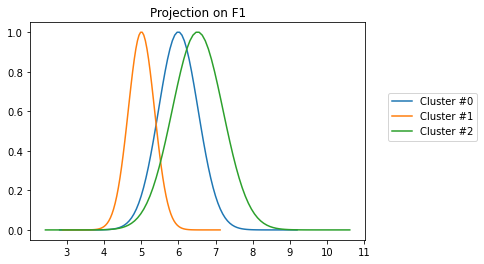

In [168]:
dim = 0
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F1")

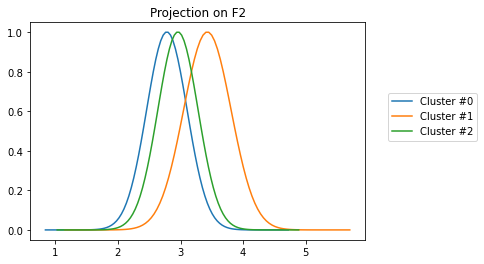

In [169]:
dim = 1
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F2")

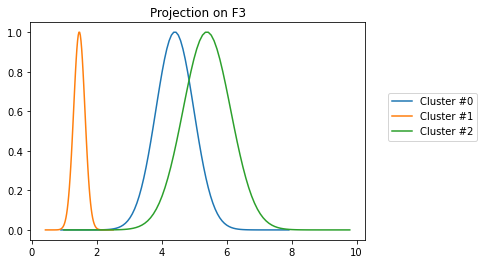

In [170]:
dim = 2
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F3")

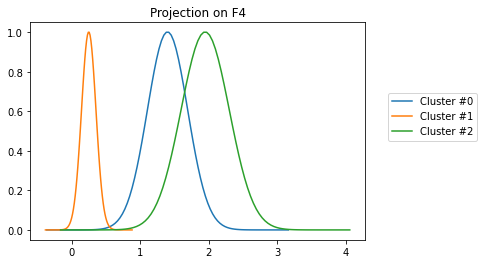

In [171]:
dim = 3
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F4")

# ELM + DBSCAN

In [124]:
def dbscan_custom(data, eps, minpts):
    print("Running DBSCAN ...")
    data = np.array(data)
    dbscan = DBSCAN(eps, minpts).fit_predict(data)
    
    return dbscan

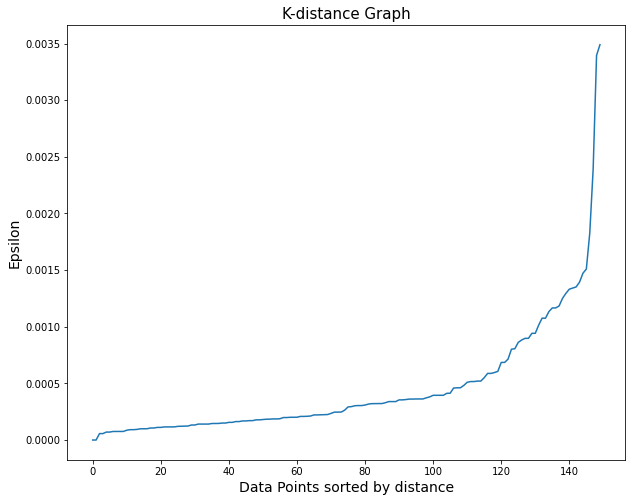

In [172]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(output_matrix)
distances, indices = nbrs.kneighbors(output_matrix)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=15)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [185]:
y_pred = dbscan_custom(output_matrix, eps=0.00125, minpts=5)

Running DBSCAN ...


/Users/nicolekan/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass min_samples=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [186]:
y_pred

array([ 0,  0,  0,  0,  0, -1, -1,  0, -1, -1,  0,  0, -1, -1, -1, -1, -1,
       -1, -1, -1,  0, -1, -1, -1, -1,  0, -1,  0,  0,  0,  0, -1, -1, -1,
        0, -1, -1, -1, -1,  0, -1, -1,  0, -1, -1, -1,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  2,  1,  1,  1,  1,  2,
        1,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [187]:
num_outliers = (np.sum(np.array(y_pred) == -1, axis=0))
num_clusters = (len(set(y_pred)) - (1 if -1 in y_pred else 0))
print('Number of noise points: ', num_outliers)
print("Number of clusters: ", num_clusters)

Number of noise points:  32
Number of clusters:  3


In [188]:
difference_in_labels(y_pred, 0)

Class
0        21
dtype: int64

In [189]:
difference_in_labels(y_pred, 1)

Class
2        50
1        40
dtype: int64

In [190]:
difference_in_labels(y_pred, 2)

Class
1        7
dtype: int64

## Projections for ELM + DBSCAN

In [191]:
for i in range(num_clusters):
    print("centroid", str(i), ": ", get_data_centroid(X, y_pred, i)[1])

centroid 0 :  [4.96190476 3.34285714 1.48571429 0.2       ]
centroid 1 :  [6.35666667 2.92444444 5.05       1.74777778]
centroid 2 :  [5.6        2.47142857 3.71428571 1.04285714]


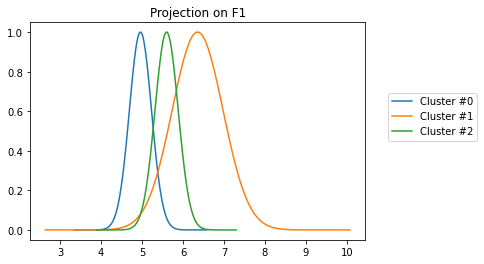

In [192]:
dim = 0
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F1")

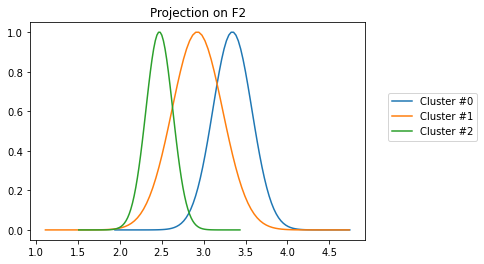

In [193]:
dim = 1
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F2")

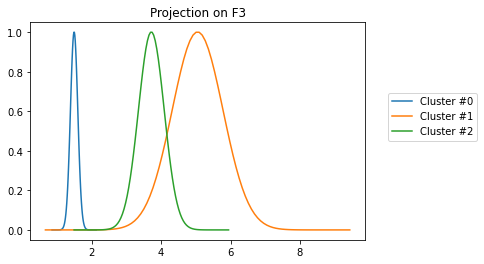

In [194]:
dim = 2
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F3")

/Users/nicolekan/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1835: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


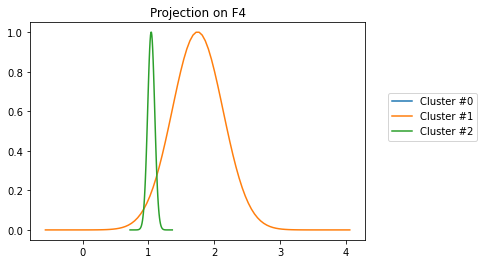

In [195]:
dim = 3
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F4")

In [196]:
dim_dict

{'cluster0': {'data': array([[5.1, 3.5, 1.4, 0.2],
         [4.9, 3. , 1.4, 0.2],
         [4.7, 3.2, 1.3, 0.2],
         [4.6, 3.1, 1.5, 0.2],
         [5. , 3.6, 1.4, 0.2],
         [5. , 3.4, 1.5, 0.2],
         [5.4, 3.7, 1.5, 0.2],
         [4.8, 3.4, 1.6, 0.2],
         [5.4, 3.4, 1.7, 0.2],
         [5. , 3. , 1.6, 0.2],
         [5.2, 3.5, 1.5, 0.2],
         [5.2, 3.4, 1.4, 0.2],
         [4.7, 3.2, 1.6, 0.2],
         [4.8, 3.1, 1.6, 0.2],
         [4.9, 3.1, 1.5, 0.2],
         [5.1, 3.4, 1.5, 0.2],
         [4.4, 3.2, 1.3, 0.2],
         [5.1, 3.8, 1.6, 0.2],
         [4.6, 3.2, 1.4, 0.2],
         [5.3, 3.7, 1.5, 0.2],
         [5. , 3.3, 1.4, 0.2]]),
  'centroid': array([4.96190476, 3.34285714, 1.48571429, 0.2       ]),
  'mean': 0.2,
  'std': 0.0},
 'cluster1': {'data': array([[7. , 3.2, 4.7, 1.4],
         [6.4, 3.2, 4.5, 1.5],
         [6.9, 3.1, 4.9, 1.5],
         [5.5, 2.3, 4. , 1.3],
         [6.5, 2.8, 4.6, 1.5],
         [5.7, 2.8, 4.5, 1.3],
         [6.3, 3.3, 

In [198]:
# Get the value of dim 3 because it has std of 0, means all values in that dimension are the same
dim_dict['cluster0']['data'][0][3]

0.2

# Fuzzy C Means

In [2]:
from fcmeans import FCM

In [199]:
num_clusters = 3
fcm = FCM(n_clusters=num_clusters)
fcm.fit(X)

In [200]:
fcm_centers = fcm.centers
y_pred = fcm.predict(X)

In [201]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2])

In [24]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2]), array([60, 50, 40]))

In [19]:
fcm_centers

array([[5.88893109, 2.76106891, 4.36394979, 1.39731409],
       [5.00396596, 3.41408892, 1.48281543, 0.25354627],
       [6.77500969, 3.05238183, 5.64677987, 2.05354592]])

In [202]:
difference_in_labels(y_pred, 0)

Class
0        50
dtype: int64

In [203]:
difference_in_labels(y_pred, 1)

Class
2        37
1         3
dtype: int64

In [204]:
difference_in_labels(y_pred, 2)

Class
1        47
2        13
dtype: int64

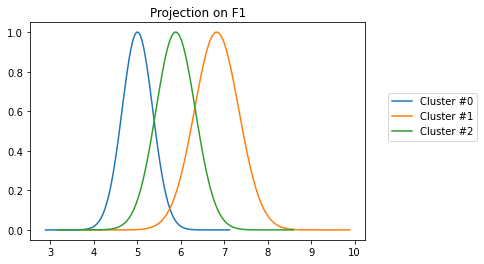

In [205]:
dim = 0
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F1")

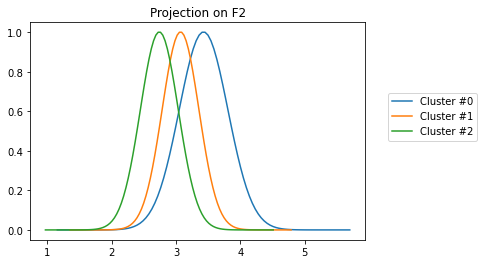

In [206]:
dim = 1
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F2")

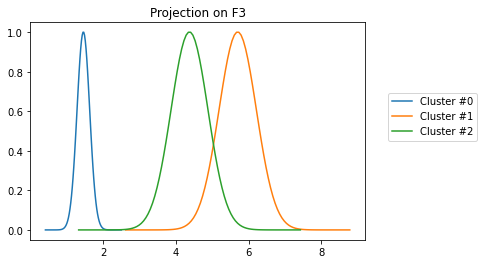

In [207]:
dim = 2
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F3")

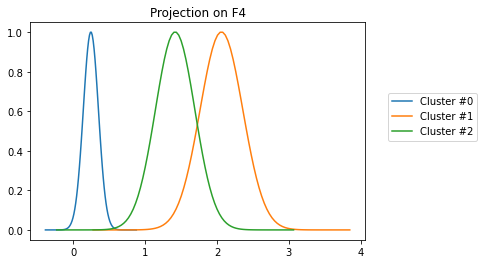

In [208]:
dim = 3
dim_dict = get_dimension_dict(X, num_clusters, dim, y_pred)
plot_projection(dim_dict, num_clusters, "Projection on F4")